In [1]:
import os
import yaml
from IPython.utils import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore") 

# from utils.models.interaction_network import InteractionNetwork
from utils.hls4ml.load_torch import load_graphs, load_models
from utils.plotting.plot_events import plot_information, plot_event
from utils.plotting.plot import watermark, infotext
from utils.hls4ml.compare import compare_hls4ml

# Load graph data (100 events)
Truncate node and edge size at 95% of sizes of all events

In [2]:
run = 'seg_1'
pz_min = 0.001
slope_max = 2.

graph_indir = f'data/graphs_{run}_pzmin_{pz_min}_slopemax_{slope_max}'
output_dir= 'hls_output/simulation/test'
# nevents = 400
n_samples = 100

graph_dims = {
    "n_node": 28,
    "n_edge": 56,
    "node_dim": 2,
    "edge_dim": 2
}

graphs = load_graphs(graph_indir, output_dir, graph_dims, n_samples)

n_graphs: 28
node dimension: torch.Size([28, 2]), edge dimension: torch.Size([56, 2])
26.0% of graphs without truncation of nodes
56.0% of graphs without truncation of edges
writing test bench data for 1st graph to hls_output/simulation/test/tb_data/input_data.dat


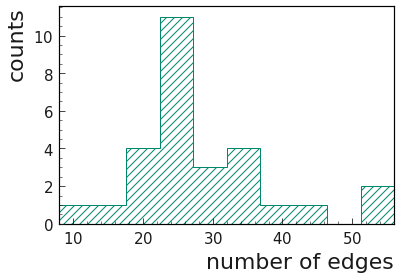

In [3]:
plt.style.use('kit_hist')

n_nodes, n_edges = [],[]
for g in graphs:
    n_nodes.append(len(g.x))
    n_edges.append(len(g.target))
plt.hist(n_edges, histtype='stepfilled', facecolor=(0,0,0,0))
plt.xlabel('number of edges')
plt.ylabel('counts')
plt.show()

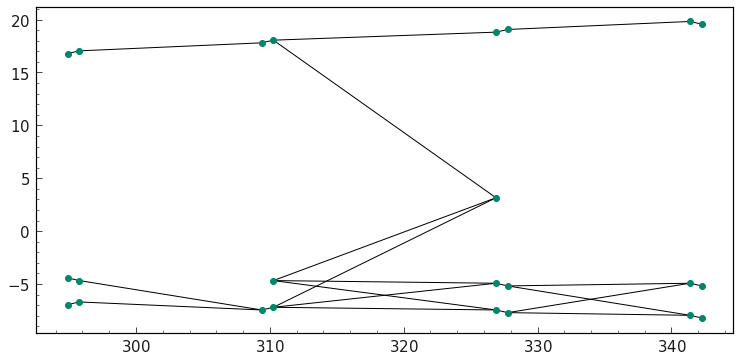

In [4]:
import matplotlib.pyplot as plt
plt.style.use('kit')


evID = np.random.randint(28)
data = graphs[evID]
X = data.x[~np.all(np.array(data.x ==0), axis=1)]
segments = data.edge_index.T[~np.all(np.array(data.edge_index.T==data.edge_index.max()), axis=1)]

plt.figure(figsize=(12.5,6))

for ids in segments:
    id1, id2 = ids
    x,z = np.vstack((X[int(id1)], X[int(id2)])).T
             
    plt.plot(z*100, x*10, linewidth=1.0, linestyle='-', marker='None', color='black') 


x,z = X.T
plt.plot(z*100, x*10, linestyle='None')
plt.show()

# Load model and compile hls model

In [5]:
nevents = 100
n_neurons=6

trained_model_dir = f'models/optimization_{run}/best/best_model_nevents_{nevents}_hidden_dim_{n_neurons}.pt'
precision = 'ap_fixed<16,8>'
index_precision = 'ap_uint<8>'
reuse = 1
part = 'xczu11eg-ffvc1760-2-e'


torch_model, hls_model, torch_wrapper = load_models(trained_model_dir, output_dir, n_neurons, precision, reuse, part,graph_dims, hls_only=False)
torch_model.count_parameters()
hls_model.compile()

print("Model compiled at: ", hls_model.config.get_output_dir())
model_config = f"precision: {precision} \nreuse_factor: {reuse}"
with open(hls_model.config.get_output_dir() + "//model_config.txt", "w") as file:
    file.write(model_config)

InteractionNetwork(node_dim: 2, edge_dim: 2, hidden_size: 6)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |     36     |
|  R1.layers.0.bias  |     6      |
| R1.layers.2.weight |     36     |
|  R1.layers.2.bias  |     6      |
| R1.layers.4.weight |     12     |
|  R1.layers.4.bias  |     2      |
| O.layers.0.weight  |     24     |
|  O.layers.0.bias   |     6      |
| O.layers.2.weight  |     36     |
|  O.layers.2.bias   |     6      |
| O.layers.4.weight  |     12     |
|  O.layers.4.bias   |     2      |
| R2.layers.0.weight |     36     |
|  R2.layers.0.bias  |     6      |
| R2.layers.2.weight |     36     |
|  R2.layers.2.bias  |     6      |
| R2.layers.4.weight |     6      |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 275
Writing HLS project
Done
Model compiled at:  hls_output/simulation/test


# Compare metrics

In [6]:
torch_error, hls_error, torch_hls_diff, wrapper_MAE, hls_output = compare_hls4ml(graphs, 
                                                                                 output_dir, 
                                                                                 torch_model, 
                                                                                 hls_model, 
                                                                                 torch_wrapper, 
                                                                                 all_metrics=True)

writing test bench golden output for 1st graph to hls_output/simulation/test/tb_data/output_predictions.dat
     single-graph wrapper-->torch MAE: 3.818422555923462e-08

     with error criteria = MAE:
          mean torch error: 0.0996054
          mean hls error: 0.1048858
          mean hls-->torch error: 0.008674421

     with error criteria = MSE:
          mean torch error: 0.043028962
          mean hls error: 0.04465037
          mean hls-->torch error: 0.00035740112

     with error criteria = RMSE:
          mean torch error: 0.15663491
          mean hls error: 0.16315927
          mean hls-->torch error: 0.015400051

     with score criteria = Accuracy:
          mean torch score: 0.9507090403941201
          mean hls score: 0.947675981709281
          mean hls-->torch score: 0.9969669413151606

     with score criteria = f1:
          mean torch score: 0.962840098171507
          mean hls score: 0.9607444528911486
          mean hls-->torch score: 0.9980648891449277

     

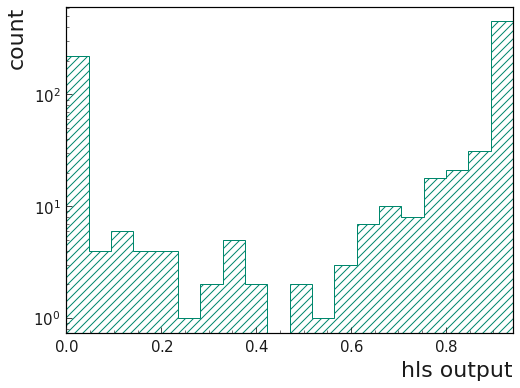

In [7]:
import matplotlib.pyplot as plt
plt.style.use('kit_hist')
plt.hist(hls_output, facecolor=(0,0,0,0), histtype='stepfilled', bins=20)
plt.yscale('log')
plt.xlabel('hls output')
plt.ylabel('count')
plt.show()

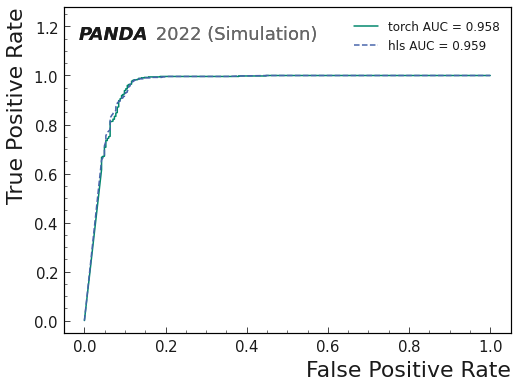

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from utils.plotting.plot import watermark

torch_roc = torch_error['ROC']
hls_roc = hls_error['ROC']

torch_auc = torch_error['AUC']
hls_auc = hls_error['AUC']

def plot_roc(roc, label):
    plt.style.use("kit")
    fpr, tpr, thresholds = roc
    auc_val=auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} AUC = {auc_val:.3f}', marker='None')
    
    watermark(py=0.9, shift=0.16, scale=1.1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.91), fontsize=12)

plt.figure(figsize=(8,6))
plot_roc(torch_roc, 'torch')    
plot_roc(hls_roc, 'hls')
plt.savefig('img/hls_roc_plot.png', bbox_inches='tight')
plt.show()



# Compare for different floating point sizes

In [9]:
nevents_range = [100, 400, 600, 1000]
nhidden_range = [3,4,5,6,7,8, 16, 32]
bits = [8,12,16,20,24]

metric_dir = 'hls_metrics/'
savename = 'hls_metrics_moregraphs.npy'

renew = False

if renew:
    index_precision = 'ap_uint<8>'
    reuse = 1
    part = 'xczu11eg-ffvc1760-2-e'
    output_dir = 'hls_output/testbla'

    torch_met = {
        "MAE": [],
        "MSE": [],
        "RMSE": [],
        'Accuracy': [],
        "f1": [],
        "AUC": [], 
        'ROC': []
        }

    hls_met = {
        "MAE": [],
        "MSE": [],
        "RMSE": [],
        'Accuracy': [],
        "f1": [],
        "AUC": [], 
        'ROC': []
        }

    diff_met = {
        "MAE": [],
        "MSE": [],
        "RMSE": [],
        'Accuracy': [],
        "f1": [],
        "AUC": [], 
        'ROC': []
        }

    torch_err = {
        "MAE": [],
        "MSE": [],
        "RMSE": [],
        'Accuracy': [],
        "f1": [],
        "AUC": [], 
        'ROC': []
        }

    hls_err = {
        "MAE": [],
        "MSE": [],
        "RMSE": [],
        'Accuracy': [],
        "f1": [],
        "AUC": [], 
        'ROC': []
        }

    diff_err = {
        "MAE": [],
        "MSE": [],
        "RMSE": [],
        'Accuracy': [],
        "f1": [],
        "AUC": [], 
        'ROC': []
        }

    for k in torch_met.keys():
        torch_met[k] = np.zeros((len(bits), len(nevents_range), len(nhidden_range)))
        hls_met[k] = np.zeros((len(bits), len(nevents_range), len(nhidden_range)))
        diff_met[k] = np.zeros((len(bits), len(nevents_range), len(nhidden_range)))
        torch_err[k] = np.zeros((len(bits), len(nevents_range), len(nhidden_range)))
        hls_err[k] = np.zeros((len(bits), len(nevents_range), len(nhidden_range)))
        diff_err[k] = np.zeros((len(bits), len(nevents_range), len(nhidden_range)))



    for i, nevents in enumerate(nevents_range):
        for j, nhidden in enumerate(nhidden_range):
            print(nevents, 'events', nhidden, 'neurons')
            model_dir = f'models/optimization_{run}/best/best_model_nevents_{nevents}_hidden_dim_{nhidden}.pt'

            for b, bit in enumerate(bits):
                precision = f'ap_fixed<{bit},{int(bit/2)}>'                
                output_dir = f"hls_output/precision_{bit}"
                with io.capture_output() as captured: 
                    torch_model, hls_model, torch_wrapper = load_models(model_dir, 
                                                                        output_dir, 
                                                                        n_neurons, 
                                                                        precision, 
                                                                        reuse, 
                                                                        part,
                                                                        graph_dims, 
                                                                        hls_only=False)
                    hls_model.compile()
                    all_torch_error, all_hls_error, all_torch_hls_diff, _, _ = compare_hls4ml(graphs, 
                                                                                              output_dir, 
                                                                                              torch_model, 
                                                                                              hls_model, 
                                                                                              torch_wrapper, 
                                                                                              all_metrics=True)


                for k in torch_err.keys():
                    torch_met[k][b,i,j] = np.nanmean(all_torch_error[k])
                    torch_err[k][b,i,j] = np.nanstd(all_torch_error[k])
                    hls_met[k][b,i,j] = np.nanmean(all_hls_error[k])
                    hls_err[k][b,i,j] = np.nanstd(all_hls_error[k])
                    diff_met[k][b,i,j] = np.nanmean(all_torch_hls_diff[k])
                    diff_err[k][b,i,j] = np.nanstd(all_torch_hls_diff[k])

    metric_dir = 'hls_metrics/'

    os.makedirs(metric_dir, exist_ok=True)

    all_metrics = [torch_met, torch_err, hls_met, hls_err, diff_met, diff_err]
    np.save(os.path.join(metric_dir, savename), all_metrics)
    
else:
    torch_met, torch_err, hls_met, hls_err, diff_met, diff_err = np.load(os.path.join(metric_dir, savename), allow_pickle=True)

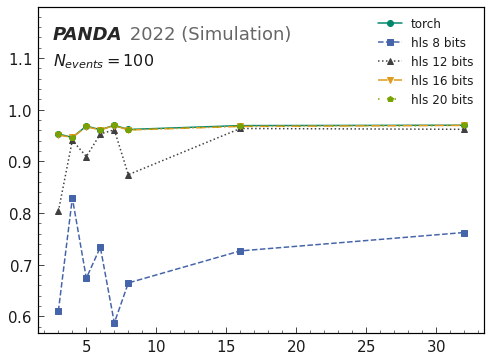

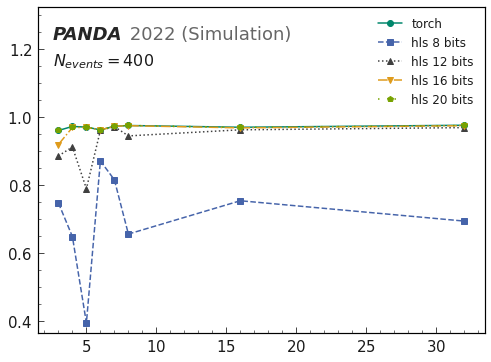

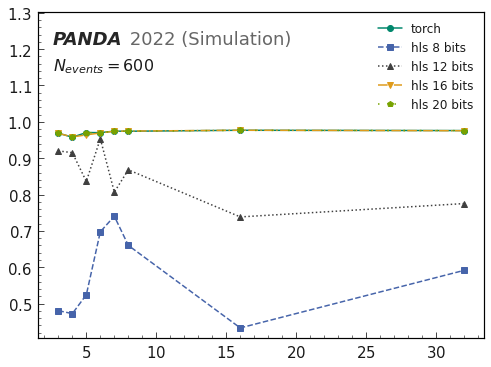

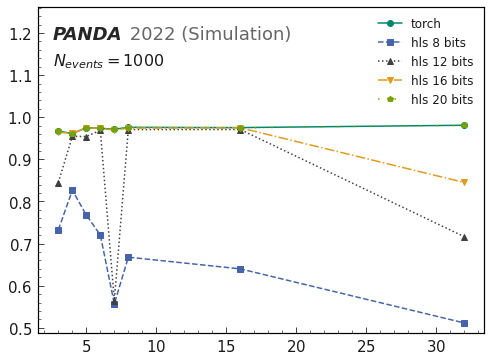

In [10]:
key = 'AUC'
labels = [str(i) for i in bits]

torchm = np.mean(torch_met[key], axis=2)
torcherr = np.std(torch_met[key], axis=2)
hlsm = np.mean(hls_met[key], axis=2)
hlserr = np.std(hls_met[key], axis=2)


plt.style.use('kit')
for N, nevents in enumerate(nevents_range): 
    plt.plot(nhidden_range, torch_met[key][0,N,:], label='torch')
    for i in range(len(bits[:-1])):
#     for i in [2]:
#         plt.errorbar(nhidden_range, hls_met[key][i,N,:], hls_err[key][i,N,:], label=labels[i])
        plt.plot(nhidden_range, hls_met[key][i,N,:], label=f'hls {labels[i]} bits')
    plt.legend(fontsize=12, loc='upper right')
    info=infotext(nevents)
    watermark(scale=1.5, information=info)
    plt.show()

In [11]:
nevents_range = [100, 400, 600, 1000, 3000]
nhidden_range = [3,4,5,6,7,8, 16, 32]
bits = [8,9,10,11,12,13,14,15,16,20,32]

rewnew2 = False

metric_dir = 'hls_metrics/'
savename = f'hls_metrics_roc_auc.npy'


index_precision = 'ap_uint<8>'
reuse = 1
part = 'xczu11eg-ffvc1760-2-e'
output_dir = 'hls_output/testbla'

if rewnew2:

    torch_roc, hls_roc, diff_roc = {}, {}, {}

    for ne in nevents_range:
        torch_roc[ne] = {}
        hls_roc[ne] = {}
        diff_roc[ne] = {}
        for nh in nhidden_range:
            torch_roc[ne][nh] = {'ROC':[], 'AUC':[]}
            hls_roc[ne][nh] = {'ROC':[], 'AUC':[]}
            diff_roc[ne][nh] = {'ROC':[], 'AUC':[]}


    for nevents in nevents_range:
        for nhidden in nhidden_range:
            print(nevents, 'events', nhidden, 'neurons')
            model_dir = f'models/optimization_{run}/best/best_model_nevents_{nevents}_hidden_dim_{nhidden}.pt'

            for bit in bits:
                precision = f'ap_fixed<{bit},{int(bit/2)}>'                
                output_dir = f"hls_output/precision_{bit}"
                with io.capture_output() as captured: 
                    torch_model, hls_model, torch_wrapper = load_models(model_dir, 
                                                                        output_dir, 
                                                                        n_neurons, 
                                                                        precision, 
                                                                        reuse, 
                                                                        part,
                                                                        graph_dims, 
                                                                        hls_only=False)
                    hls_model.compile()
                    all_torch_error, all_hls_error, all_torch_hls_diff, _, _ = compare_hls4ml(graphs, 
                                                                                              output_dir, 
                                                                                              torch_model, 
                                                                                              hls_model, 
                                                                                              torch_wrapper, 
                                                                                              all_metrics=False)


                torch_roc[nevents][nhidden]['ROC'].append(all_torch_error['ROC'])
                hls_roc[nevents][nhidden]['ROC'].append(all_hls_error['ROC'])
                diff_roc[nevents][nhidden]['ROC'].append(all_torch_hls_diff['ROC'])

                torch_roc[nevents][nhidden]["AUC"].append(auc(all_torch_error['ROC'][0], all_torch_error['ROC'][1]))
                hls_roc[nevents][nhidden]["AUC"].append(auc(all_hls_error['ROC'][0], all_hls_error['ROC'][1]))
                diff_roc[nevents][nhidden]["AUC"].append(auc(all_torch_hls_diff['ROC'][0], all_torch_hls_diff['ROC'][1]))

    metric_dir = 'hls_metrics/'
    os.makedirs(metric_dir, exist_ok=True)

    np.save(os.path.join(metric_dir, savename), [torch_roc, hls_roc, diff_roc])
    
else:
    torch_roc, hls_roc, diff_roc = np.load(os.path.join(metric_dir, savename), allow_pickle=True)
    

In [12]:
from sklearn.metrics import auc

def plot_roc(roc, label):
    plt.style.use("kit")
    fpr, tpr, thresholds = roc
    auc_val=auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} AUC = {auc_val:.3f}', marker='None')    
    return auc_val

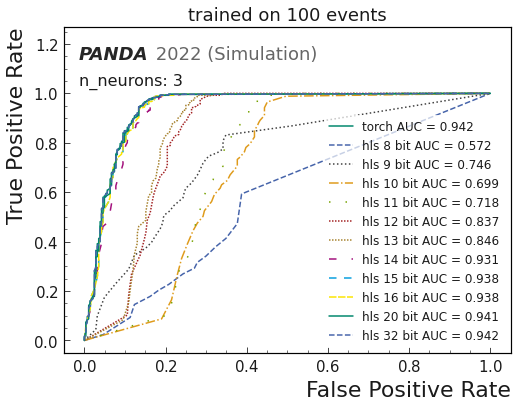

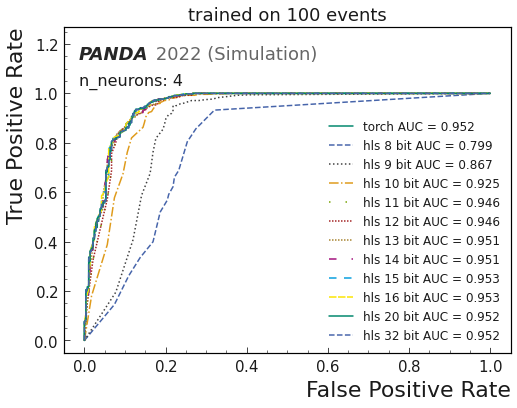

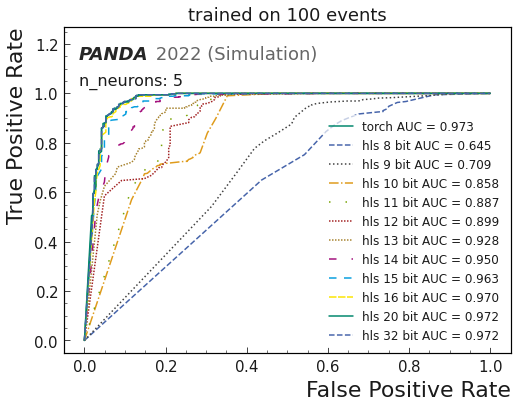

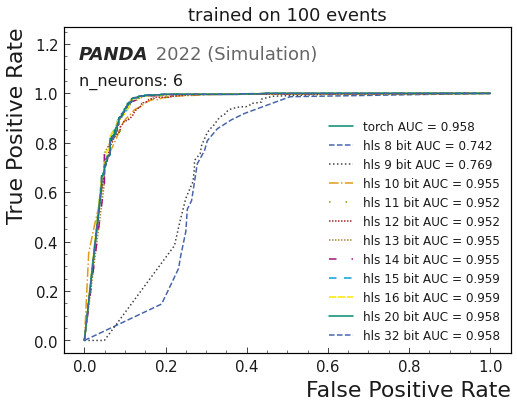

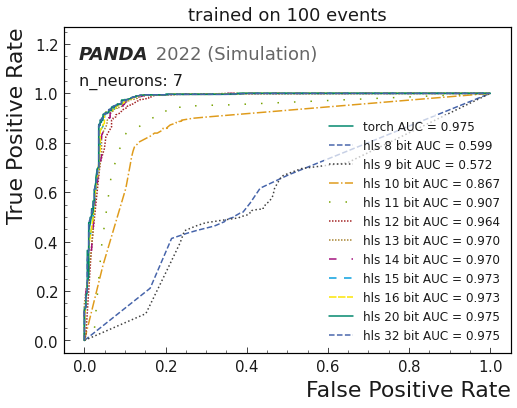

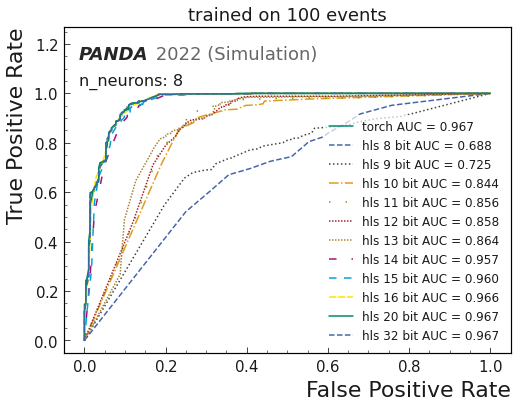

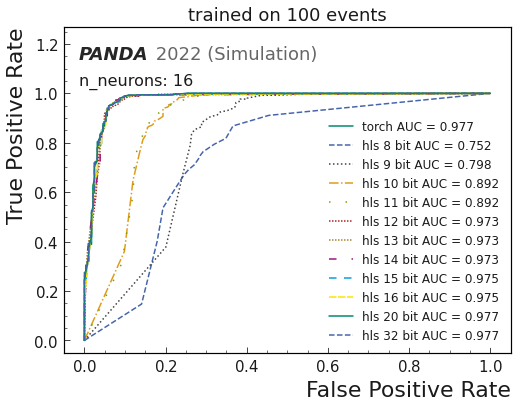

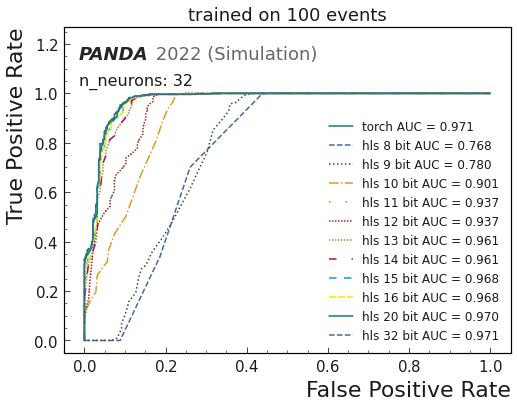

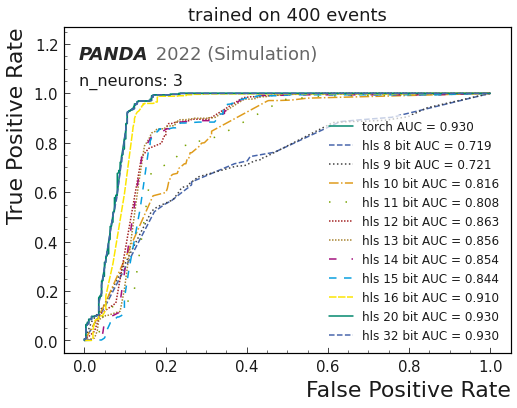

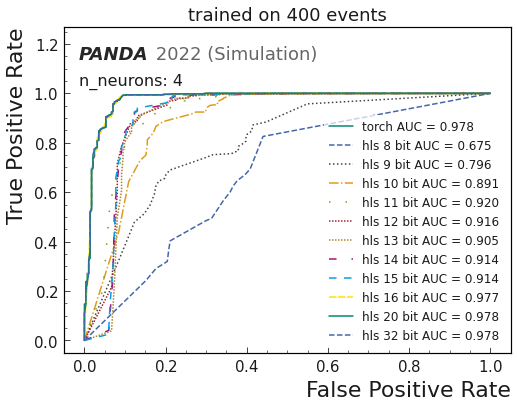

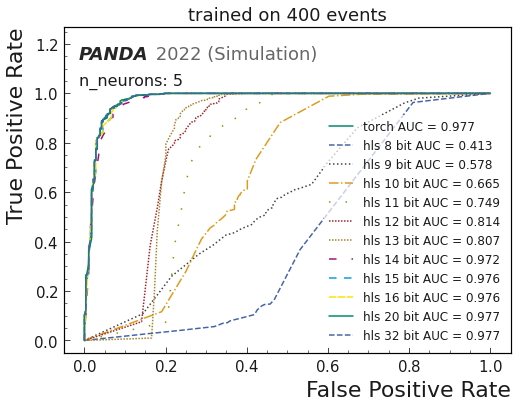

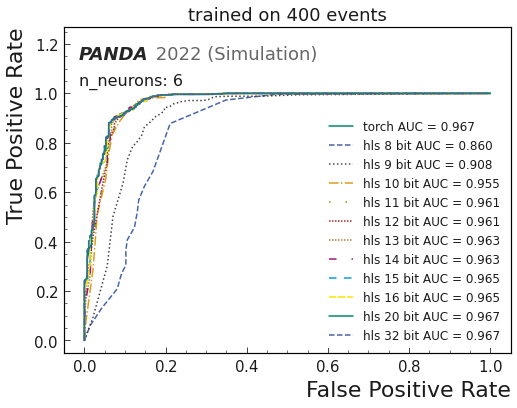

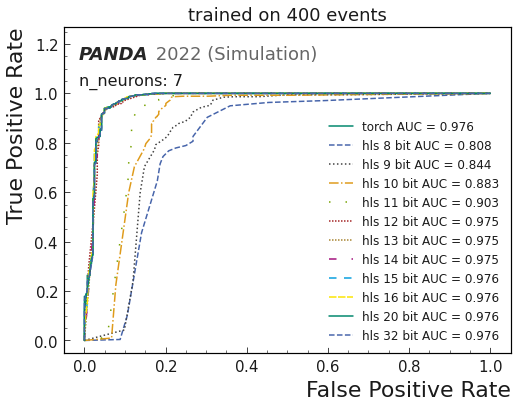

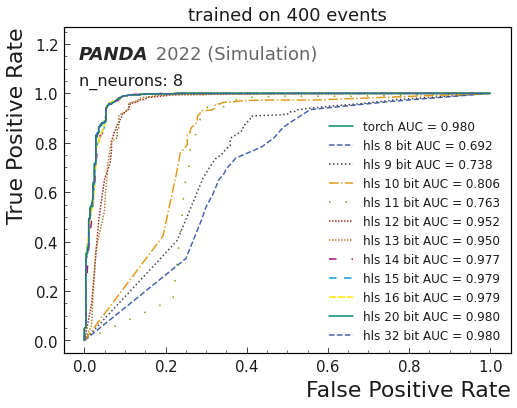

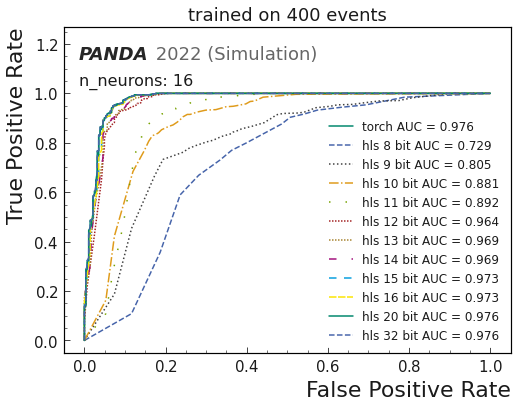

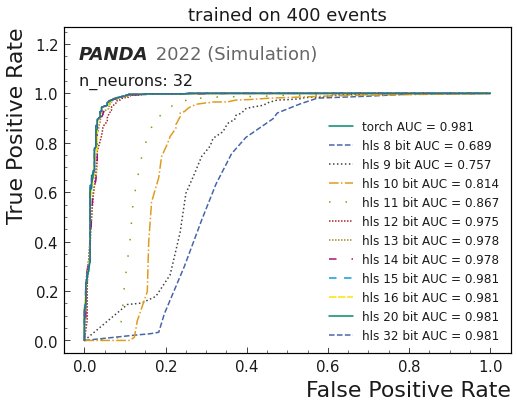

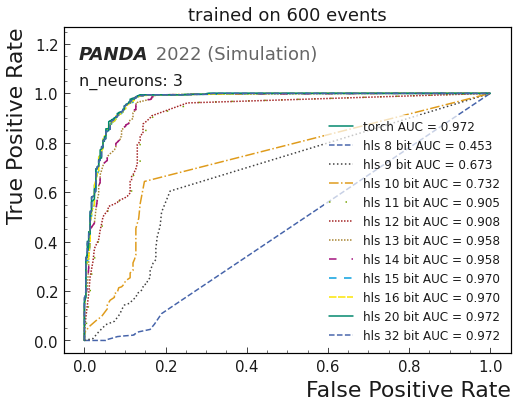

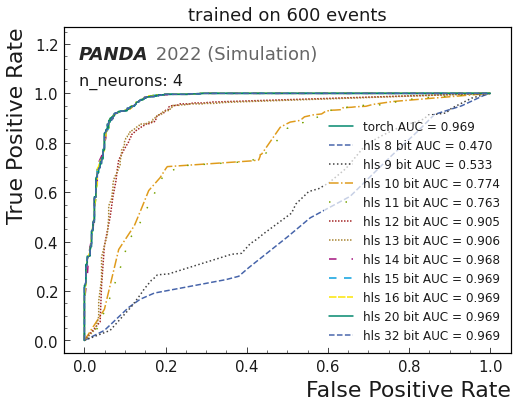

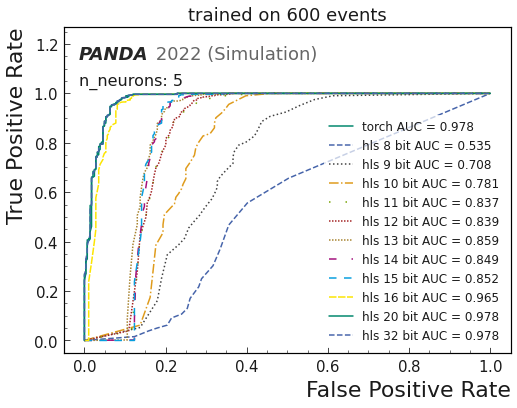

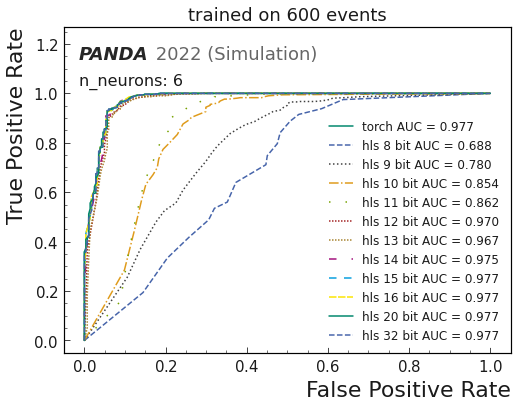

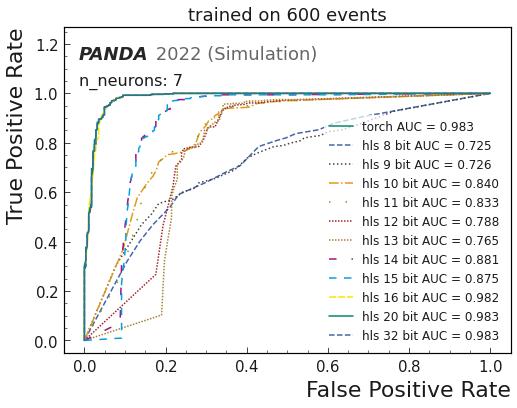

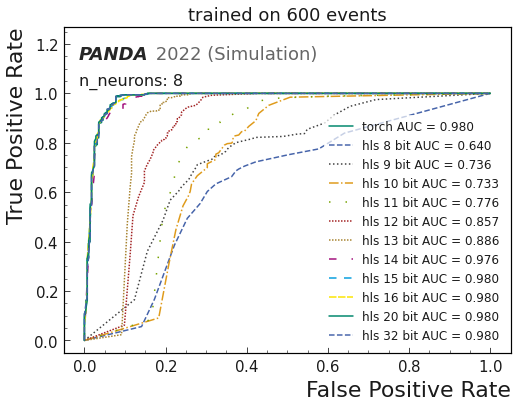

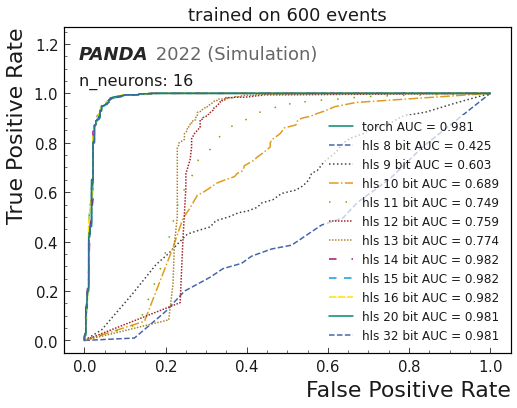

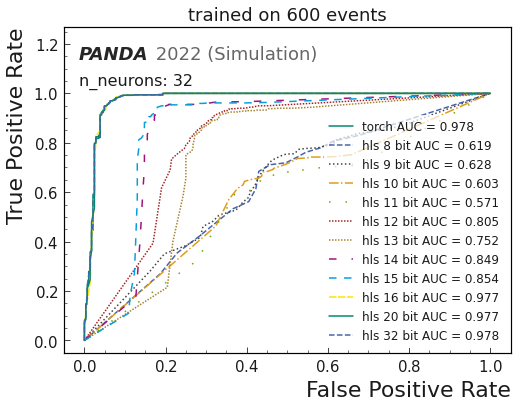

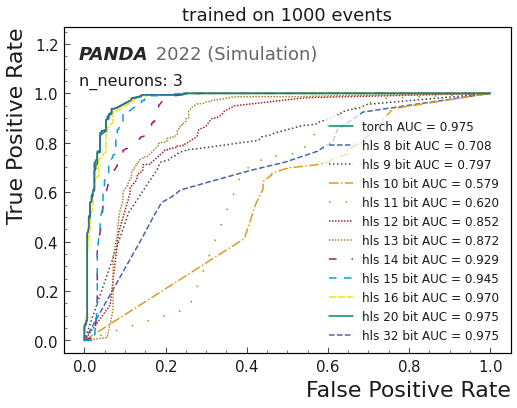

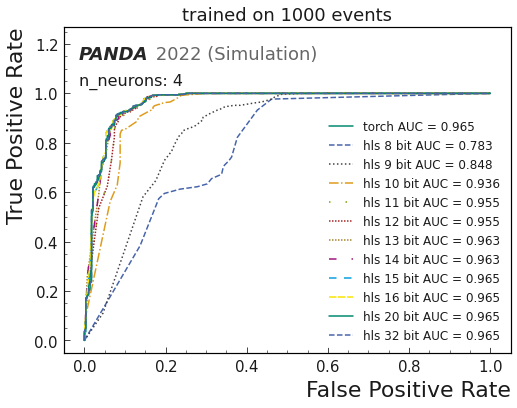

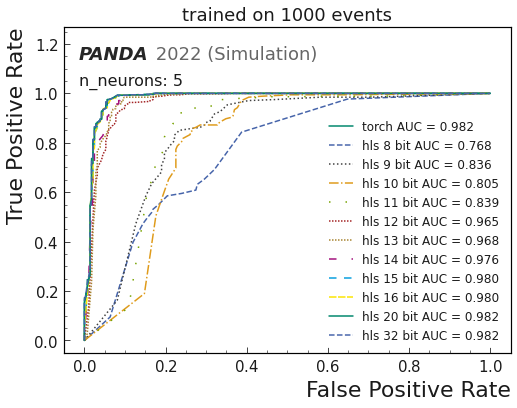

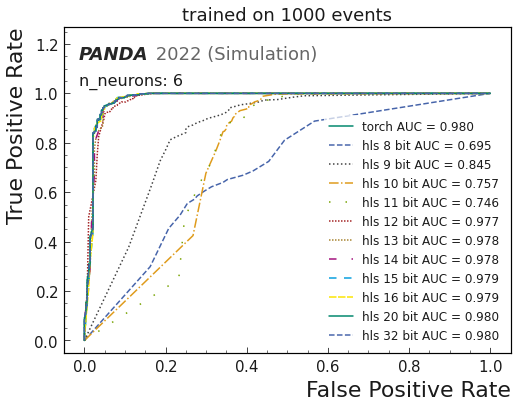

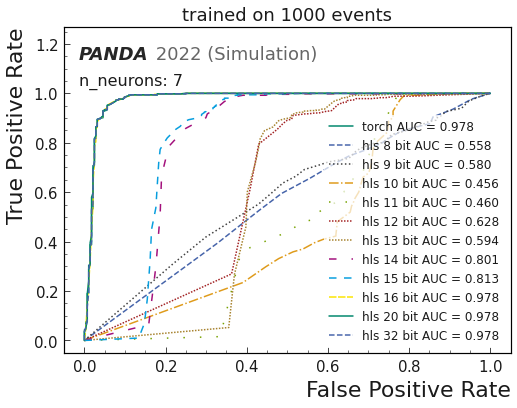

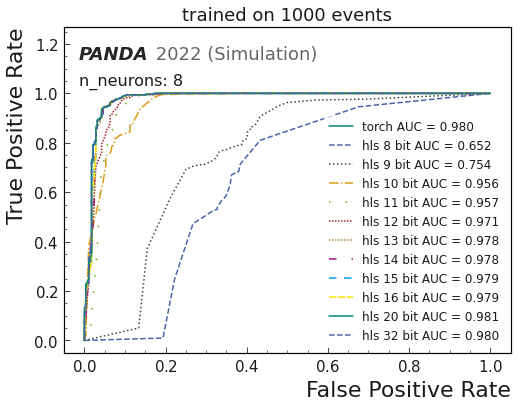

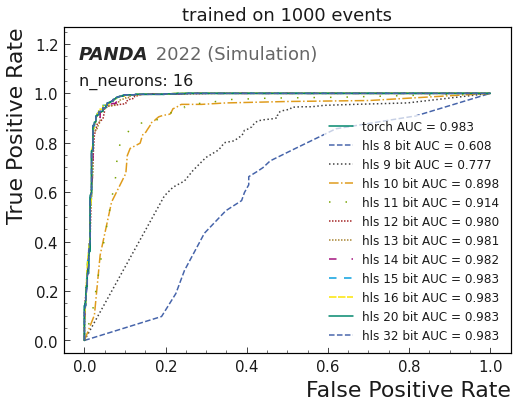

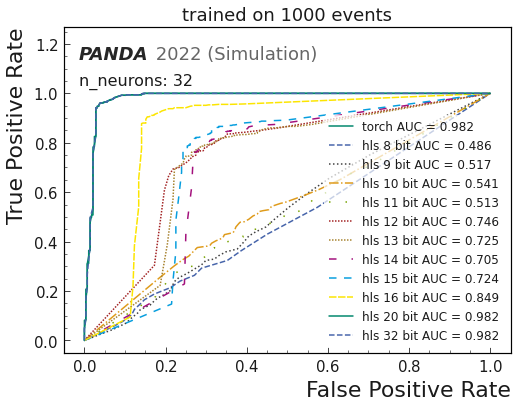

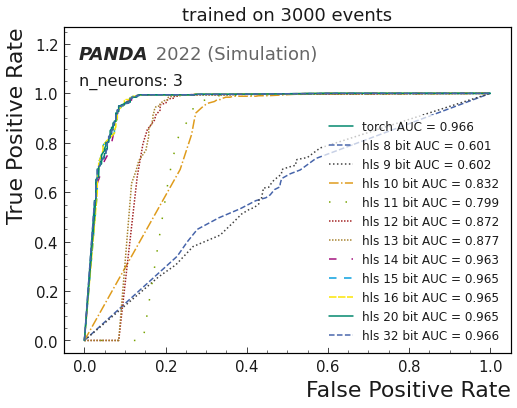

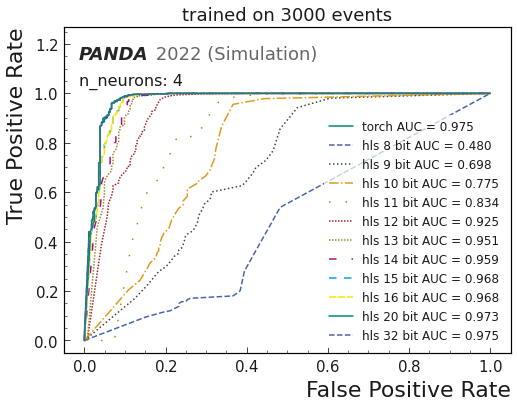

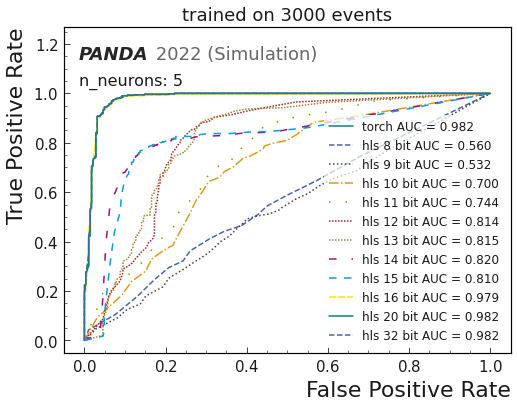

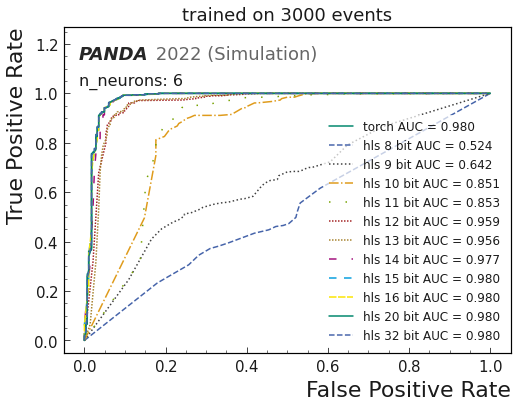

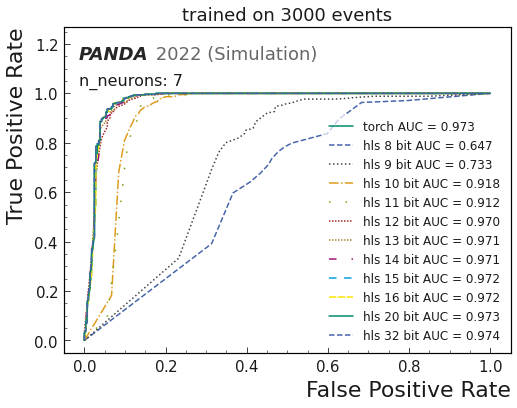

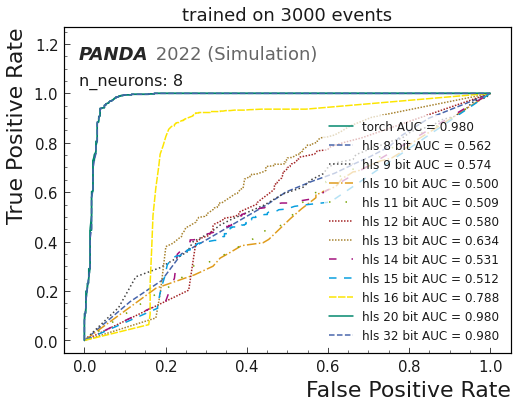

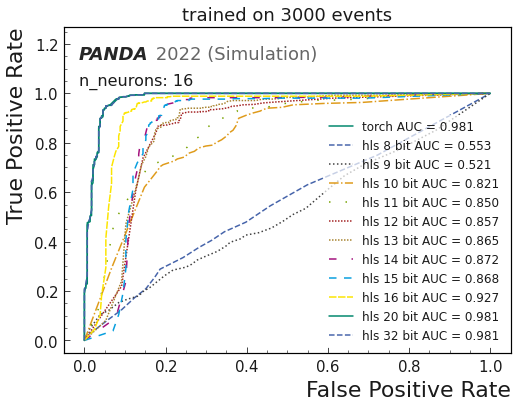

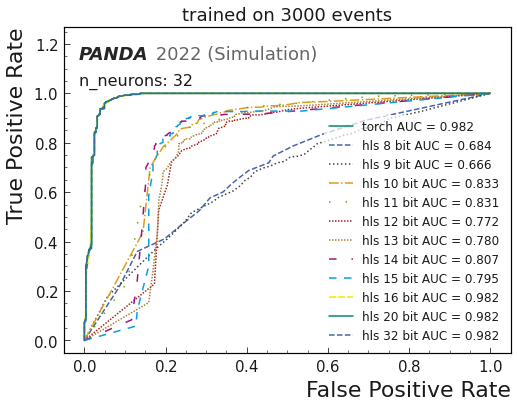

In [13]:
for ne in nevents_range:
    for nh in nhidden_range:

        aucs = np.zeros(len(bits))

        plot_roc(torch_roc[ne][nh]['ROC'][0], 'torch') 
        for i,b in enumerate(bits):

            aucs[i] = plot_roc(hls_roc[ne][nh]['ROC'][i], f'hls {b} bit')

#         aucs[6] = plot_roc(hls_roc[ne][nh]['ROC'][6], f'hls {b} bit')

        watermark(py=0.9, shift=0.16, scale=1.2, information=f'n_neurons: {nh}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'trained on {ne} events')
        plt.legend(loc='lower right', fontsize=12, frameon = True, framealpha = 0.7, facecolor = 'white', edgecolor = 'white')
        plt.show()

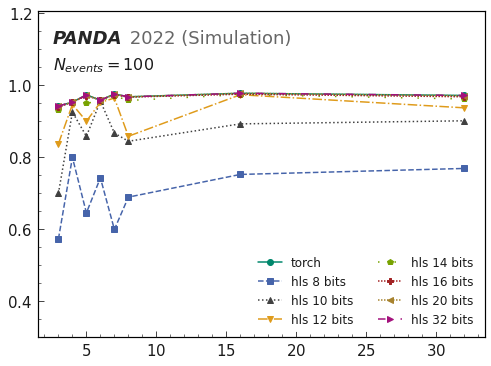

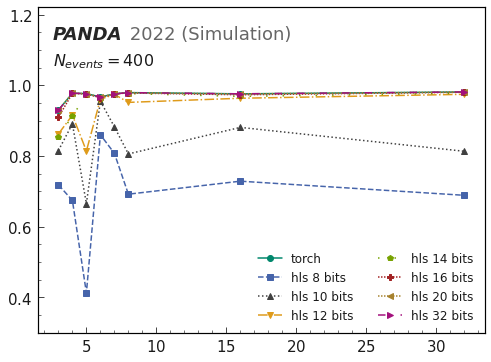

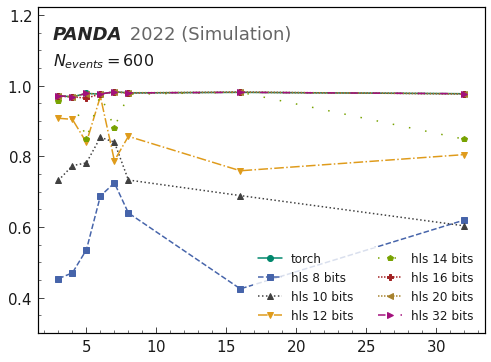

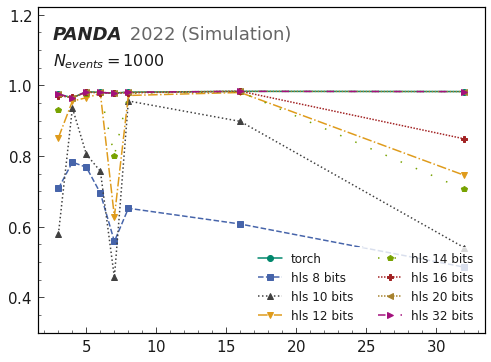

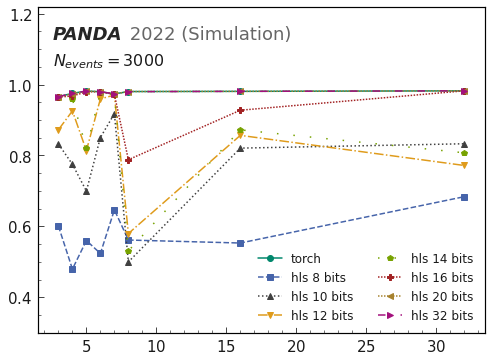

In [14]:
bits = [8,9,10,11,12,13,14,15,16,20,32]

labels = [str(i) for i in bits]

plt.style.use('kit')
for nevents in nevents_range: 
    torch_aucs, hls_aucs  = [], []
    for i, nhidden in enumerate(nhidden_range):
        torch_aucs.append(np.mean(torch_roc[nevents][nhidden]['AUC']))
        hls_aucs.append(hls_roc[nevents][nhidden]['AUC'])    
    
    plt.plot(nhidden_range, torch_aucs, label='torch')
    
    for i in range(len(bits)):
        if i in [0,2,4,6,8,9,10]:
            plt.plot(nhidden_range, np.transpose(hls_aucs)[i], label=f'hls {labels[i]} bits')
    plt.legend(fontsize=12, loc='lower right', ncol=2, frameon = True, framealpha = 0.8, facecolor = 'white', edgecolor = 'white')
    plt.ylim(0.3)
    info=infotext(nevents)
    watermark(scale=1.3, information=info)
    plt.show()

# Build HLS
This is not the compilation output of this script but of another one from the given directory

In [15]:
import hls4ml
hls4ml.report.read_vivado_report('hls_output/test/')

Found 1 solution(s) in hls_output/test//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Thu Jul 21 11:26:12 2022

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu9eg-ffvb1156-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.357 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+----------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline |
    |   min   |   max   |    min   |    max   | min | max |   Type   |
    +---------+---------+----------+---

# Test dummy data inference

for simple comparison with Vivado network inference simulation

In [16]:
import torch
import numpy as np

data = graphs[11]

data.x = torch.zeros(data.x.shape)
data.edge_attr = torch.zeros(data.edge_attr.shape)
test = np.arange(0,data.edge_index.shape[1])

data.edge_index = torch.tensor((test, 37-test), dtype=torch.long) % data.x.shape[0]


torch_pred = torch_model(data).detach().cpu().numpy()

In [17]:
print(data.edge_index)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27,  0,  1,  2,  3,  4,  5,  6,  7,
          8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
         26, 27],
        [ 9,  8,  7,  6,  5,  4,  3,  2,  1,  0, 27, 26, 25, 24, 23, 22, 21, 20,
         19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,
          1,  0, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12,
         11, 10]])


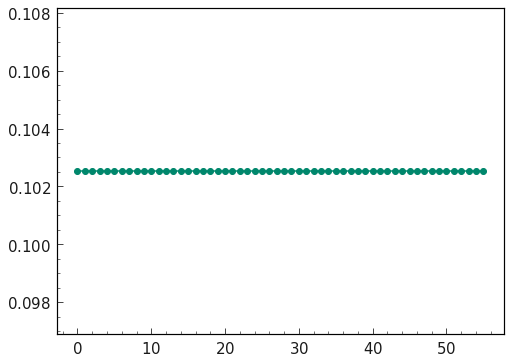

In [18]:
plt.plot(torch_pred)